In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import requests
import json
import re
import geopy.geocoders as gc
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [2]:
decisions_data = pd.read_csv("data/Filtered_ZBA_decisions.csv")
meetings_data = pd.read_csv("data/Filtered_ZBA_meetings.csv")
decisions_data

,Source,Case Number,Applicant Address,Decision (Approve/Reject)
0,ZBA Decision 2017,BOA-639633,"105 Allston Street, Ward 21",Approved
1,ZBA Decision 2017,BOA-652473,"65 Ashland Street, Ward 16",Approved
2,ZBA Decision 2017,BOA-640152,"29 Batchelder Street, Ward 8",Approved
3,ZBA Decision 2017,BOA-640141,"21-27 Batchelder Street, Ward 8",Approved
4,ZBA Decision 2017,BOA-568164,"474 Beacon Street, Ward 5",Approved
...,...,...,...,...
2916,ZBA Decision 2019,BOA-892970,"91A Baker Street, Ward 20",Denied
2917,ZBA Decision 2019,BOA-822030,"212 Chelsea Street, Ward 1",Denied
2918,ZBA Decision 2019,BOA-864614,"118-120 Granite Avenue, Ward 16",Denied
2919,ZBA Decision 2019,BOA-865287,"54 High Street, Ward 2",Denied


We have saved the process data to a csv; here we try to load it

In [3]:
csv_loaded = False
try:
    decisions_with_demos = pd.read_csv('data/decisions_with_demographics.csv')
    csv_loaded = True
except:
    csv_loaded = False

In [4]:
meetings_data

,Source,Case Number,Applicant,Applicant Address
0,ZBA Meeting 2018,BOA-379892,Michael Cronin,42 Thompson Street Ward 18
1,ZBA Meeting 2018,BOA-645234,Andrew Kara,45-55 Brighton Avenue Ward 21
2,ZBA Meeting 2018,BOA-645231,Andrew Kara,75 Gardner Street Ward 21
3,ZBA Meeting 2018,BOA-382897,Ruth Silman,104 Canal Street Ward 3
4,ZBA Meeting 2018,BOA-694026,Richard Lynds,77-85 Liverpool Street Ward 1
...,...,...,...,...
2998,ZBA Meeting 2017,BOA719303,James Christopher,"435 Hyde Park AV, Ward - 19"
2999,ZBA Meeting 2017,BOA730816,Elba Rojas,"82 Cummins HW, Ward - 19"
3000,ZBA Meeting 2017,BOA730716,John Harrington,"177 Glenellen Rd, Ward - 20"
3001,ZBA Meeting 2017,BOA732458,Patrick Mahoney,"118 - 122 Tremont St, Ward - 22"


In [5]:
if not csv_loaded:
    decisions_data['Case Number'] = decisions_data.apply(lambda row: re.sub("[^0-9]", "", row['Case Number']), axis=1)
    decisions_data

In [6]:
if not csv_loaded:
    meetings_data = meetings_data[meetings_data['Case Number'].notna()]
    meetings_data['Case Number'] = meetings_data.apply(lambda row: re.sub("[^0-9]", "", row['Case Number']), axis=1)
    meetings_data

In [7]:
if not csv_loaded:
    meetings_with_decisions = pd.merge(meetings_data, decisions_data, left_on="Case Number", right_on="Case Number")
    meetings_with_decisions = meetings_with_decisions.drop(columns=['Applicant Address_x', 'Source_x', 'Source_y'])
    meetings_with_decisions = meetings_with_decisions.rename(columns={'Applicant Address_y': 'Address'})
    meetings_with_decisions

Now to format the addresses to have "Boston, MA" in them so geopy knows whats up

In [8]:
def formatAddress(row):
    addr = row['Address']
    addr = addr.split(",")
    return addr[0].strip() + ", Boston, MA"

In [9]:
if not csv_loaded:
    meetings_with_decisions['Address'] = meetings_with_decisions.progress_apply(formatAddress, axis=1)

In [10]:
gc.options.default_timeout = 10
geolocator = gc.Nominatim(user_agent="Baystate_Banner_Boston_Building_Binvestigators")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.05)
location = geolocator.geocode("175 5th Avenue NYC")
location.latitude

43.3545384

In [11]:
# meetings_with_decisions = meetings_with_decisions[:400]
if not csv_loaded:
    meetings_with_decisions['geocodes'] = meetings_with_decisions['Address'].progress_apply(geolocator.geocode)
    meetings_with_decisions

In [12]:
if not csv_loaded:
    filtered_meetings_with_decisions = meetings_with_decisions[meetings_with_decisions['geocodes'].notna()]
    filtered_meetings_with_decisions

In [13]:
if not csv_loaded:
    filtered_meetings_with_decisions['lat'] = filtered_meetings_with_decisions.progress_apply(lambda row: row['geocodes'].latitude, axis=1)
    filtered_meetings_with_decisions['long'] = filtered_meetings_with_decisions.progress_apply(lambda row: row['geocodes'].longitude, axis=1)
    filtered_meetings_with_decisions

In [14]:
if not csv_loaded:
    sub_neigh = pd.read_csv("data/Sub-Neighborhoods.csv")
    sub_neigh['Census Tract#'] = sub_neigh.progress_apply(lambda row: float(row['Census Tract#']), axis=1)
    sub_neigh['White Proportion'] = sub_neigh.progress_apply(lambda row: float(row['White Proportion'][:-1]), axis=1)
    sub_neigh

In [15]:
# Function to convert the Lat and Long into a census tract.
# Refer to https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html for the FIPS code to census tract conversion
# FCC Census block conversion API link: https://geo.fcc.gov/api/census/#!/block/get_block_find

def Coord_to_census_tract(Lat,Long):
    Converter = requests.get("https://geo.fcc.gov/api/census/block/find?latitude=%20" + str(Lat) + "&longitude=" + str(Long) + "&showall=true&format=json")
    #print(Converter.text)
    Census_data = Converter.text
    json_data = json.loads(Census_data)
    # print(json_data)
    FIPS_code = json_data['Block']['FIPS']
    if FIPS_code is None:
        return "nan"
    Census_tract = FIPS_code[5:11]
    #print(type(Census_tract))
    if Census_tract[0] == "0":
        Census_tract.replace(Census_tract[0],'')
        Census_split = Census_tract[ : 4] + '.'+ Census_tract[4 : ]
        return(Census_split)
    else:
        Census_split = Census_tract[ : 4] + '.'+ Census_tract[4 : ]
        return(Census_split)

In [16]:
if not csv_loaded:
    filtered_meetings_with_decisions['Cencus Tract'] = filtered_meetings_with_decisions.progress_apply(lambda row: float(Coord_to_census_tract(row.lat, row.long)), axis=1)
    filtered_meetings_with_decisions = filtered_meetings_with_decisions[filtered_meetings_with_decisions['Cencus Tract'].notna()]
    decisions_with_demos = pd.merge(filtered_meetings_with_decisions, sub_neigh, left_on="Cencus Tract", right_on="Census Tract#")
    decisions_with_demos

In [17]:
if not csv_loaded:
    decisions_with_demos.to_csv('data/decisions_with_demographics.csv')
    decisions_with_demos

In [18]:
grouped_neighs = decisions_with_demos.groupby('Neighborhood')
grouped_neighs_stats = grouped_neighs.agg(["size", np.mean])['White Proportion']
grouped_neighs_approved = decisions_with_demos[decisions_with_demos['Decision (Approve/Reject)'] == 'Approved'].groupby('Neighborhood')
grouped_neighs_approved_size = grouped_neighs_approved.agg(["size", np.mean])['White Proportion']
grouped_neighs_approved_size['Real Mean'] = grouped_neighs_stats['mean']
grouped_neighs_approved_size = grouped_neighs_approved_size.sort_values('Real Mean', ascending=False)['size']
grouped_neighs_stats = grouped_neighs_stats.sort_values('mean', ascending=False)
grouped_neighs_approved_size

Neighborhood
North End                   20
South Boston               241
Beacon Hill                 55
Back Bay                    40
Charlestown                 87
South Boston Waterfront     13
East Boston                224
West Roxbury                50
Jamaica Plain               59
Brighton                   110
Fenway                      27
West End                     5
South End                   61
Allston                     84
Downtown                   103
Roslindale                 198
Mission Hill                13
Dorchester                 406
Hyde Park                   61
Roxbury                    157
Mattapan                    18
Name: size, dtype: int64

In [19]:
grouped_neighs_stats

,size,mean
Neighborhood,,
North End,21,95.523810
South Boston,272,94.142463
Beacon Hill,60,93.573333
Back Bay,42,87.444524
Charlestown,95,86.547263
South Boston Waterfront,13,86.050000
East Boston,244,85.723484
West Roxbury,61,82.084590
Jamaica Plain,75,73.269867


In [40]:
def plot_stuff(grouped_stats, num_approved, num_denied, title, xlabel, figsize=[30,10]):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("# of decisions")

    ind = np.arange(len(grouped_stats))
    p1 = plt.bar(ind, num_approved, width, label="Approved", color='teal')
    p2 = plt.bar(ind, num_denied, width, bottom=num_approved, label="Denied", color='lightcoral')

    plt.legend()
    xtix = [grouped_stats['size'].index[i] + " (" + str(int(grouped_stats['mean'][i])) + "%)" for i in range(len(grouped_stats['size'].index))]
    plt.xticks(ind, xtix, rotation=36)

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for i in range(len(rects)):
            rect = rects[i]
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., grouped_stats['size'][i] + 8,
                    '%d%%' % ((num_denied[i] / (num_denied[i] + num_approved[i])) * 100),
                    ha='center', va='bottom')

    autolabel(p1)

    plt.show()

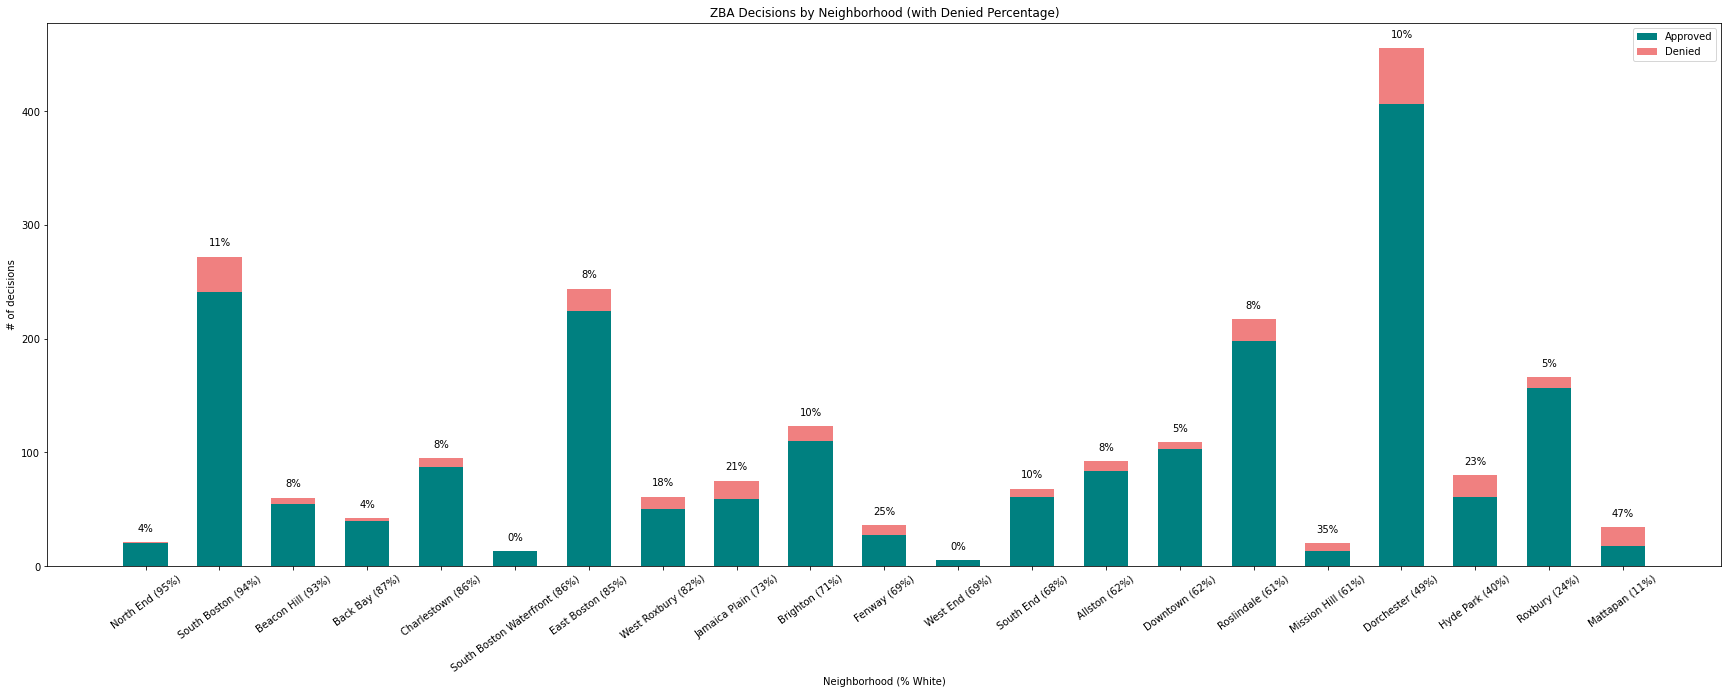

In [41]:
num_approved = grouped_neighs_approved_size.values
num_denied = np.array(grouped_neighs_stats['size'].values) - np.array(grouped_neighs_approved_size.values)
width = 0.6

title = "ZBA Decisions by Neighborhood (with Denied Percentage)"
xlab = "Neighborhood (% White)"
plot_stuff(grouped_neighs_stats, num_approved, num_denied, title, xlab)

In [21]:
grouped_neighs_maj_white = grouped_neighs_stats[grouped_neighs_stats['mean'] >= 50.0]
grouped_neighs_maj_nonwhite = grouped_neighs_stats[grouped_neighs_stats['mean'] < 50.0]
grouped_neighs_maj_white_approved = grouped_neighs_approved_size[grouped_neighs_stats['mean'] >= 50.0]
grouped_neighs_maj_nonwhite_approved = grouped_neighs_approved_size[grouped_neighs_stats['mean'] < 50.0]
grouped_neighs_maj_nonwhite

,size,mean
Neighborhood,,
Dorchester,455,49.675385
Hyde Park,80,40.174375
Roxbury,166,24.906024
Mattapan,34,11.425294


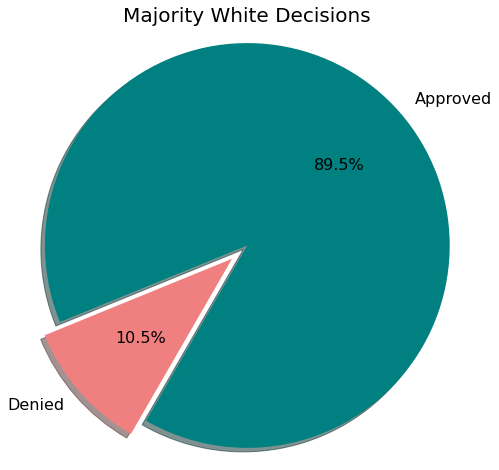

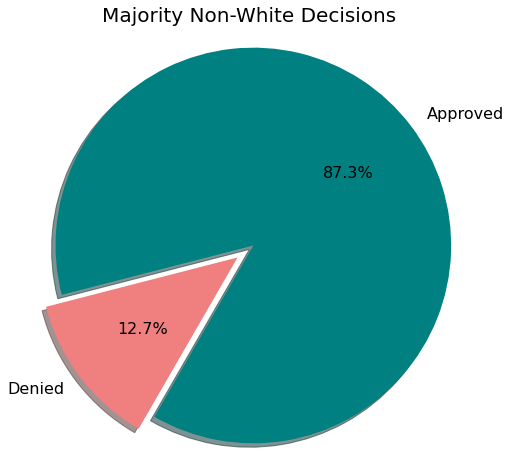

In [22]:
total_decisions = sum(grouped_neighs_maj_white['size'].values)
total_approvals = sum(grouped_neighs_maj_white_approved.values)
total_denials = total_decisions - total_approvals

plt.figure(figsize=[8,8])
plt.title("Majority White Decisions", fontdict={'fontsize': 20})
plt.pie([total_approvals, total_denials], (0, 0.1), startangle=-120, shadow=True, autopct="%1.1f%%", labels=['Approved', 'Denied'], colors=['teal', 'lightcoral'], textprops={'fontsize': 16})
plt.axis('equal')
plt.show()

total_decisions = sum(grouped_neighs_maj_nonwhite['size'].values)
total_approvals = sum(grouped_neighs_maj_nonwhite_approved.values)
total_denials = total_decisions - total_approvals

plt.figure(figsize=[8,8])
plt.title("Majority Non-White Decisions", fontdict={'fontsize': 20})
plt.pie([total_approvals, total_denials], (0, 0.1), startangle=-120, shadow=True, autopct="%1.1f%%", labels=['Approved', 'Denied'], colors=['teal', 'lightcoral'], textprops={'fontsize': 16})
plt.axis('equal')
plt.show()

In [30]:
roxbury_stats = grouped_neighs_stats[(grouped_neighs_stats.index == 'Roxbury') | (grouped_neighs_stats.index == 'West Roxbury')]
roxbury_stats

,size,mean
Neighborhood,,
West Roxbury,61,82.084590
Roxbury,166,24.906024


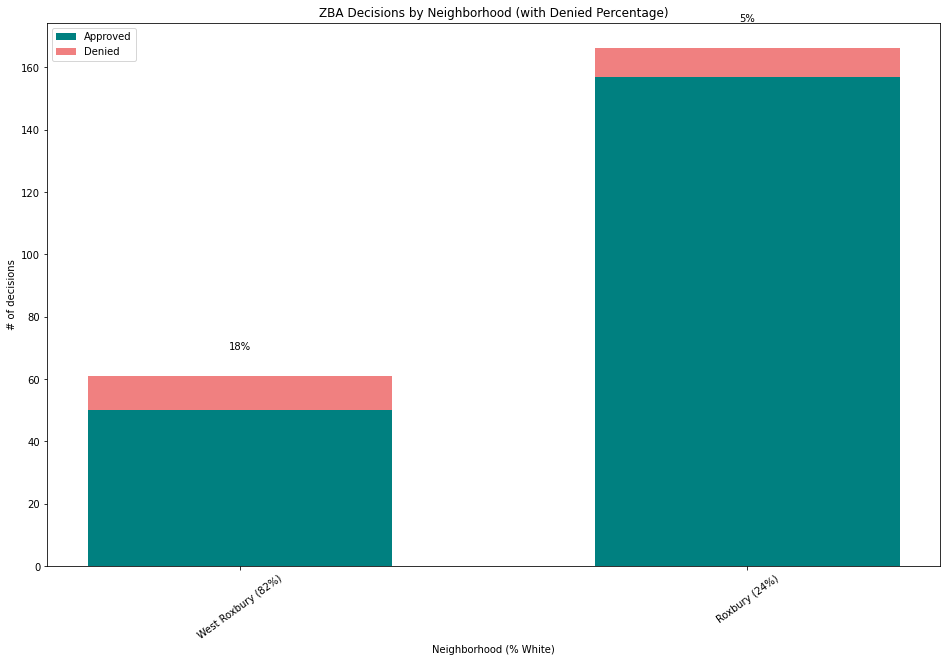

In [131]:
rox_num_approved = num_approved[[7, 19]]
rox_num_denied = num_denied[[7, 19]]
width = 0.6

plot_stuff(roxbury_stats, rox_num_approved, rox_num_denied, title, xlab, [16,10])

In [132]:
def clean_names(row):
    # print(row[3])
    name = row['Applicant']
    name = str(name)
    name = name.replace(" ", "")
    name = name.replace("\n", "")
    name = name.split(",")[0]
    name = name.lower()
    row['Applicant'] = name
    return row

grouped_apps = decisions_with_demos.progress_apply(clean_names, axis=1).groupby('Applicant')
grouped_apps_stats = grouped_apps.agg("size").sort_values(ascending=False)
grouped_apps_stats

100%|██████████| 2288/2288 [00:00<00:00, 18905.77it/s]


Applicant
patrickmahoney             79
georgemorancy              73
johnpulgini                59
johngorman                 48
timothyjohnson             38
                           ..
leonela.pazanddoras.paz     1
lennoxalfred                1
leighcarloni                1
leeharvey                   1
10-11arlingtonllc           1
Length: 1096, dtype: int64

In [133]:
grouped_apps_approved_stats = decisions_with_demos.progress_apply(clean_names, axis=1)[decisions_with_demos['Decision (Approve/Reject)'] == 'Approved'].groupby('Applicant').agg("size").sort_values(ascending=False)
grouped_apps_approved_stats

100%|██████████| 2288/2288 [00:00<00:00, 19468.89it/s]


Applicant
patrickmahoney                     76
georgemorancy                      66
johnpulgini                        53
johngorman                         48
timothyjohnson                     38
                                   ..
lindaneshemkinfor270bakerstreet     1
lindaneshemkinfor                   1
libertycompassion                   1
lexingtonprescott                   1
10-11arlingtonllc                   1
Length: 1023, dtype: int64

In [134]:
merged = pd.DataFrame(grouped_apps_stats).merge(pd.DataFrame(grouped_apps_approved_stats), left_index=True, right_index=True)
grouped_apps_all_stats = merged.rename(columns={'0_x': 'total', '0_y': 'approved'})
grouped_apps_all_stats['denied'] = grouped_apps_all_stats['total'] - grouped_apps_all_stats['approved']
grouped_apps_all_stats

,total,approved,denied
Applicant,,,
patrickmahoney,79,76,3
georgemorancy,73,66,7
johnpulgini,59,53,6
johngorman,48,48,0
timothyjohnson,38,38,0
...,...,...,...
leonela.pazanddoras.paz,1,1,0
lennoxalfred,1,1,0
leighcarloni,1,1,0


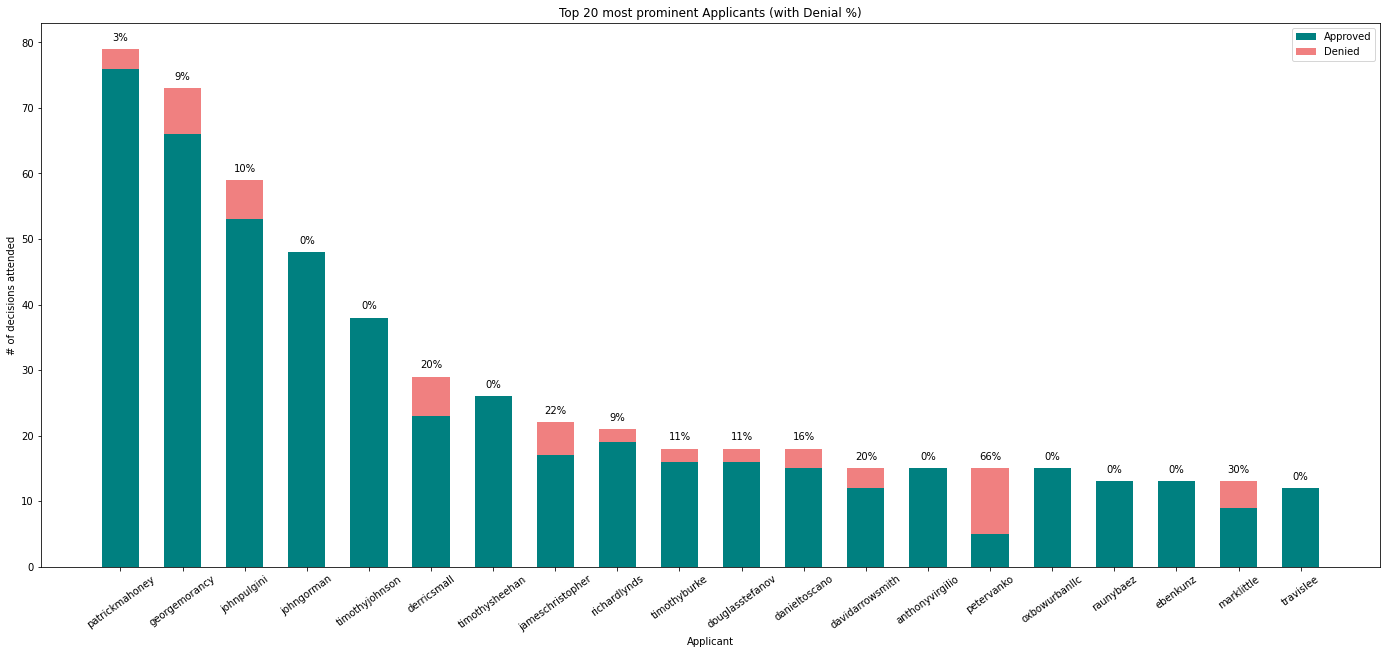

In [140]:
grouped_apps_all_stats = grouped_apps_all_stats[:20]
apps_num_approved = grouped_apps_all_stats['approved'].values
apps_num_denied = grouped_apps_all_stats['denied'].values

plt.figure(figsize=[24,10])
plt.title("Top 20 most prominent Applicants (with Denial %)")
plt.xlabel("Applicant")
plt.ylabel("# of decisions attended")

ind = np.arange(len(grouped_apps_all_stats))
p1 = plt.bar(ind, apps_num_approved, width, label="Approved", color='teal')
p2 = plt.bar(ind, apps_num_denied, width, bottom=apps_num_approved, label="Denied", color='lightcoral')

plt.legend()
xtix = grouped_apps_all_stats.index
plt.xticks(ind, xtix, rotation=36)

def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for i in range(len(rects)):
            rect = rects[i]
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., grouped_apps_all_stats['total'][i] + 1,
                    '%d%%' % ((apps_num_denied[i] / (apps_num_denied[i] + apps_num_approved[i])) * 100),
                    ha='center', va='bottom')

autolabel(p1)

plt.show()

In [136]:
decisions_with_demos_poc = decisions_with_demos[decisions_with_demos['White Proportion'] < 50.0]
grouped_apps_poc = decisions_with_demos_poc.progress_apply(clean_names, axis=1).groupby('Applicant')
grouped_apps_poc_stats = grouped_apps_poc.agg("size").sort_values(ascending=False)
grouped_apps_poc_approved_stats = decisions_with_demos_poc.progress_apply(clean_names, axis=1)[decisions_with_demos_poc['Decision (Approve/Reject)'] == 'Approved'].groupby('Applicant').agg("size").sort_values(ascending=False)

merged = pd.DataFrame(grouped_apps_poc_stats).merge(pd.DataFrame(grouped_apps_poc_approved_stats), left_index=True, right_index=True)
grouped_apps_poc_all_stats = merged.rename(columns={'0_x': 'total', '0_y': 'approved'})
grouped_apps_poc_all_stats['denied'] = grouped_apps_poc_all_stats['total'] - grouped_apps_poc_all_stats['approved']

100%|██████████| 496/496 [00:00<00:00, 15497.31it/s]


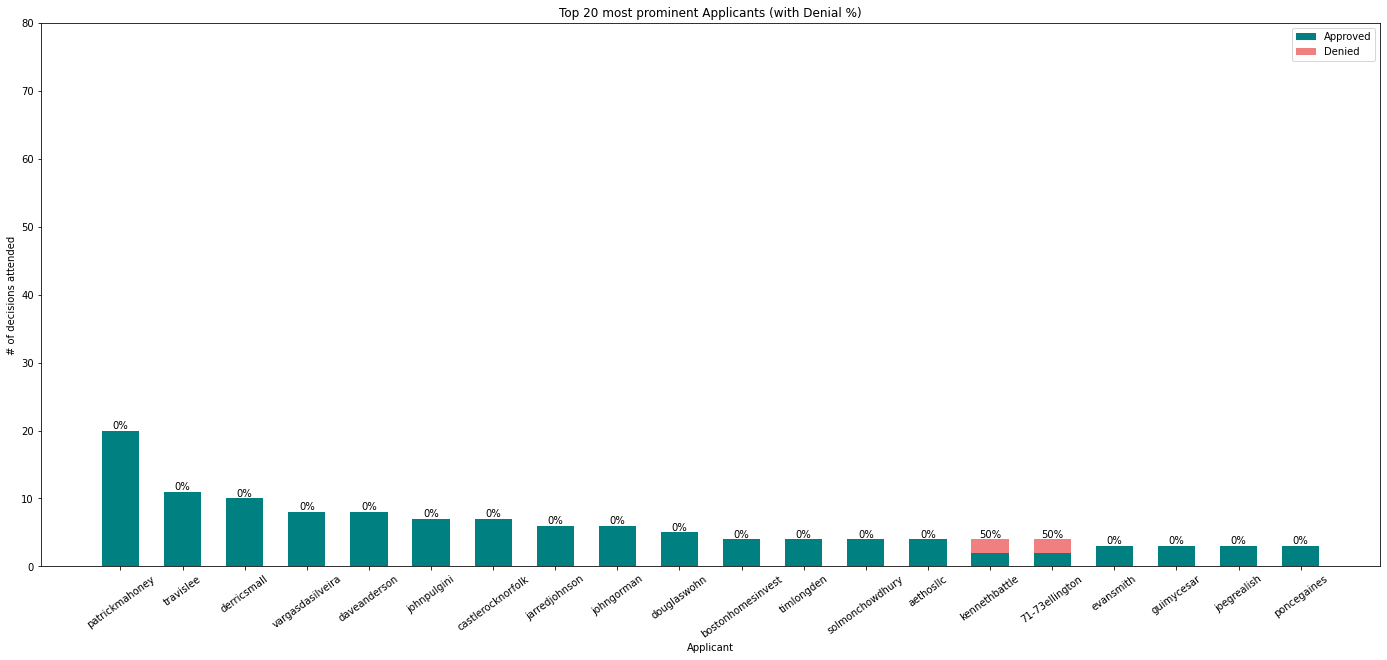

In [139]:
grouped_apps_poc_all_stats = grouped_apps_poc_all_stats[:20]
apps_num_approved = grouped_apps_poc_all_stats['approved'].values
apps_num_denied = grouped_apps_poc_all_stats['denied'].values

plt.figure(figsize=[24,10])
plt.title("Top 20 most prominent Applicants (with Denial %)")
plt.xlabel("Applicant")
plt.ylabel("# of decisions attended")
plt.gca().set_ylim([0, 80])


ind = np.arange(len(grouped_apps_poc_all_stats))
p1 = plt.bar(ind, apps_num_approved, width, label="Approved", color='teal')
p2 = plt.bar(ind, apps_num_denied, width, bottom=apps_num_approved, label="Denied", color='lightcoral')

plt.legend()
xtix = grouped_apps_poc_all_stats.index
plt.xticks(ind, xtix, rotation=36)

def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for i in range(len(rects)):
            rect = rects[i]
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., grouped_apps_poc_all_stats['total'][i],
                    '%d%%' % ((apps_num_denied[i] / (apps_num_denied[i] + apps_num_approved[i])) * 100),
                    ha='center', va='bottom')

autolabel(p1)

plt.show()